# Taxi Order Prediction

The company "Sharp Taxi" has collected historical data on taxi orders at airports. In order to attract more drivers during peak hours, it is necessary to forecast the number of taxi orders for the next hour. A model needs to be built for this prediction.

The RMSE metric on the test set should not exceed 48.

Research Steps:

1. Load the data and resample it by one hour.
2. Analyze the data.
3. Train different models with various hyperparameters. Create a test set of 10% of the original data.
4. Evaluate the models on the test set and draw conclusions.


The data is stored in the file _taxi.csv_. The number of orders is located in the `num_orders` column.

## Table of Contents

1. [Preparation](#Preparation)
2. [Analysis](#Analysis)
3. [Training](#Training)
4. [Testing](#Testing)
5. [Conclusion](#Conclusion)

## Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from catboost import CatBoostRegressor

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import root_mean_squared_error

RANDOM_STATE = 42
TEST_SIZE = 0.1

In [2]:
data = pd.read_csv('/Users/dmslavin/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<AxesSubplot:title={'center':'Taxi orders by hour'}, xlabel='datetime'>

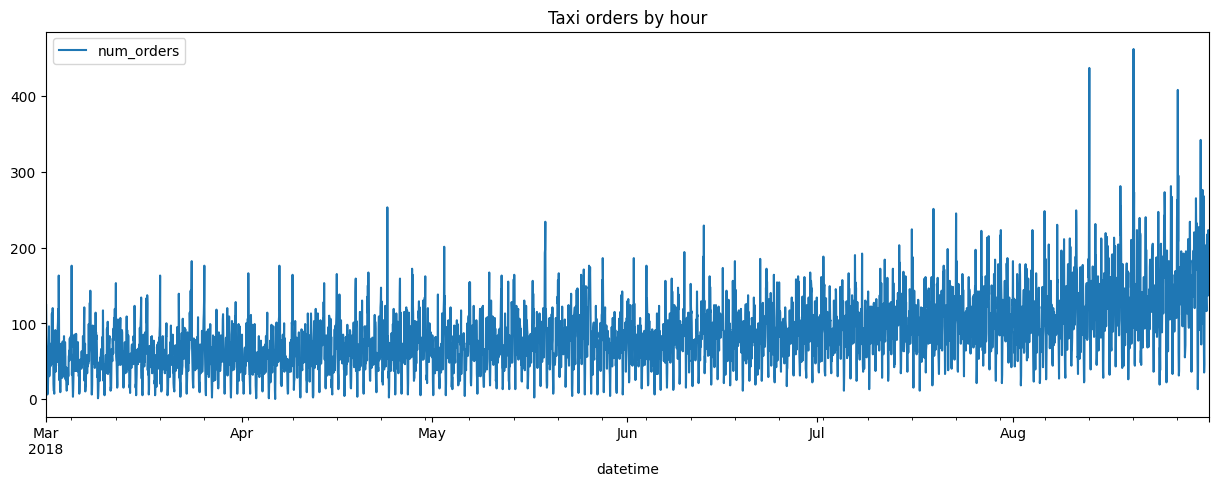

In [3]:
data = data.resample('1H').sum()
data.plot(figsize=(15, 5), title='Taxi orders by hour')


**Results**

The data has been loaded, with dates set as indices. The data period spans from 2018-03-01 00:00:00 to 2018-08-31 23:50:00. Resampling has been performed at an hourly interval (orders have been summed).


## Analysis

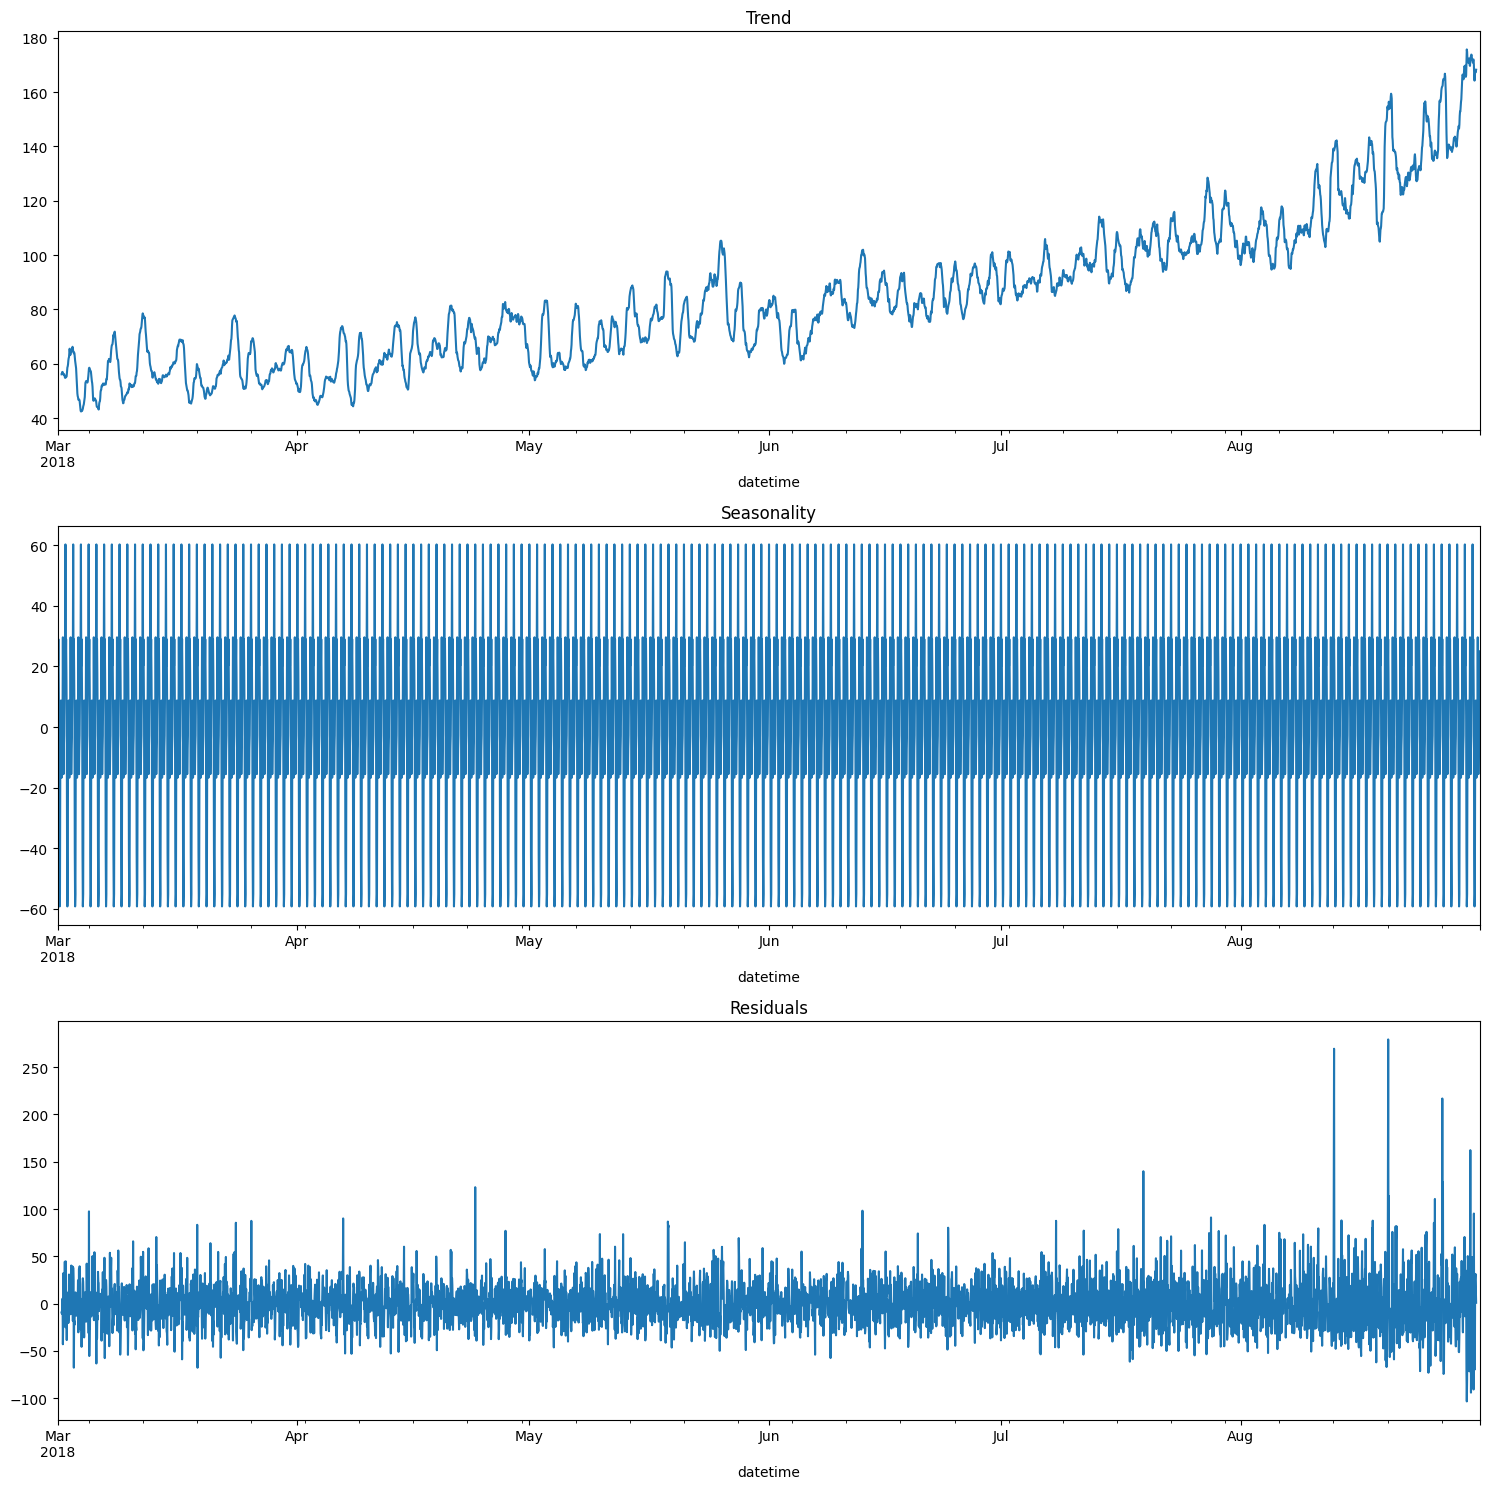

In [4]:
# decompose the time series into three components: trend, seasonality, and residuals

decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Text(0.5, 1.0, 'Seasonality')

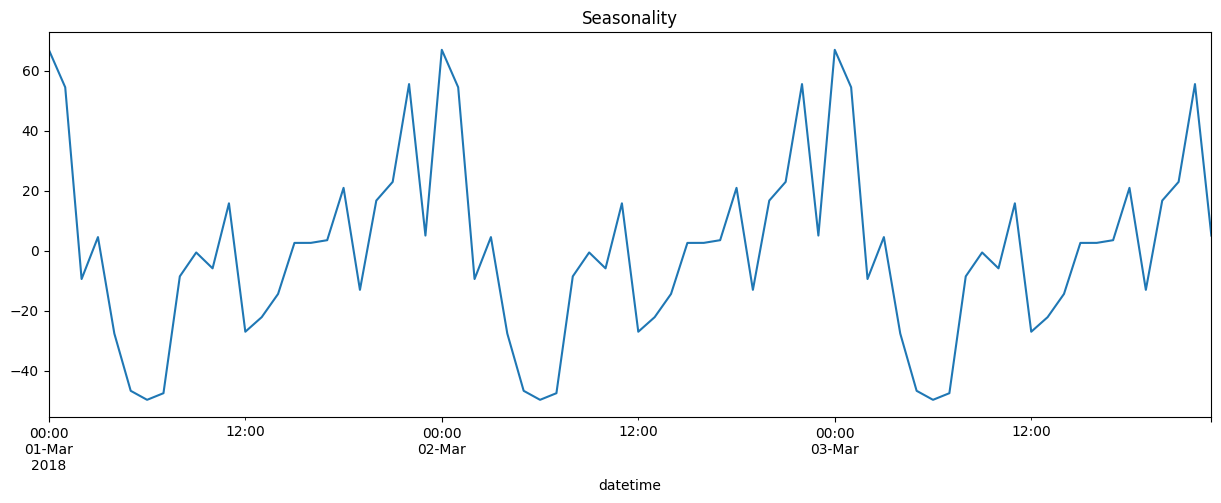

In [5]:
# explore the seasonality - take a 3-day period
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-03'])

plt.figure(figsize=(15, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')


**Results**

- From March to August, the number of taxi orders is increasing.
- There is a daily cycle in the number of orders — more orders in the evening, with a decrease at night.

## Training

In [6]:
# function to create features
def make_features(data, max_lag, rolling_mean_size):
    data1 = data.copy()
    data1['month'] = data1.index.month
    data1['hour'] = data1.index.hour
    data1['day'] = data1.index.day
    data1['dayofweek'] = data1.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data1['lag_{}'.format(lag)] = data1['num_orders'].shift(lag)

    data1['rolling_mean'] = data1['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data1

In [7]:
data1 = make_features(data, 24, 12)
data1.head(7)

,num_orders,month,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,5,1,3,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,6,1,3,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# training and test datasets

train, test = train_test_split(data1, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()

y_train = train['num_orders']
X_train = train.drop('num_orders', axis=1)
y_test = test['num_orders']
X_test = test.drop('num_orders', axis=1)

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((3950,), (3950, 29), (442,), (442, 29))

In [9]:
tscv = TimeSeriesSplit(n_splits=4)

In [10]:
# model #0 - linear regression

model0 = Ridge(random_state=RANDOM_STATE)

param_grid0 = {
        'alpha': [0.01, 0.1, 1, 10, 20, 50, 100, 200]
}

grid0 = GridSearchCV(
    model0, 
    param_grid=param_grid0, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

grid0.fit(X_train, y_train)


print('Best model and its parameters is\n\n', grid0.best_estimator_)
print ('RMSE of the best model using cross-validation is', round(np.abs(grid0.best_score_), 2))

Best model and its parameters is

 Ridge(alpha=100, random_state=42)
RMSE of the best model using cross-validation is 27.11


In [11]:
# model #1 - gradient boosting using CatBoost

model1 = CatBoostRegressor()

param_grid1 = {
        'iterations': [10, 20, 30],
        'verbose': [10]
}

grid1 = GridSearchCV(
    model1, 
    param_grid=param_grid1, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

grid1.fit(X_train, y_train)


print('Best model and its parameters is\n\n', grid1.best_estimator_)
print ('RMSE of the best model using cross-validation is', round(np.abs(grid1.best_score_), 2))

Learning rate set to 0.5
0:	learn: 31.3791206	total: 60.8ms	remaining: 1.16s
10:	learn: 22.0414221	total: 132ms	remaining: 108ms
19:	learn: 19.9865572	total: 209ms	remaining: 0us
Best model and its parameters is

RMSE of the best model using cross-validation is 26.29


In [12]:
# model 2 - decision tree

model2 = DecisionTreeRegressor(random_state=RANDOM_STATE)

param_grid2 = {
    'min_samples_leaf': range(1, 7),
    'min_samples_split': range(2, 7),
    'max_depth': range(2, 7)
} 

grid2 = GridSearchCV(
    model2, 
    param_grid=param_grid2, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

grid2.fit(X_train, y_train)


print('Best model and its parameters is\n\n', grid2.best_estimator_)
print ('RMSE of the best model using cross-validation is', round(np.abs(grid2.best_score_), 2))

Best model and its parameters is

 DecisionTreeRegressor(max_depth=6, min_samples_leaf=6, random_state=42)
RMSE of the best model using cross-validation is 30.21


## Results

Features were created: hour, day, month, weekday, 24 previous features, and a 12-day rolling mean.

Three types of models were trained:

1. Model 0 - Linear Regression (Ridge): The RMSE of the best model using cross-validation: 27.11
2. Model 1 - Gradient Boosting using CatBoost with iteration tuning: The RMSE of the best model using cross-validation: 26.29
3. Model 2 - Decision Tree: The RMSE of the best model using cross-validation: 30.21

The RMSE metric is lowest for the gradient boosting model with CatBoost. This is the best model.

## Testing

In [13]:
best_model = grid1.best_estimator_

In [14]:
# model predictions on the test dataset

pred = best_model.predict(X_test)
print("RMSE на тестовой выборке:", round(root_mean_squared_error(y_test, pred), 2) )

RMSE на тестовой выборке: 44.86


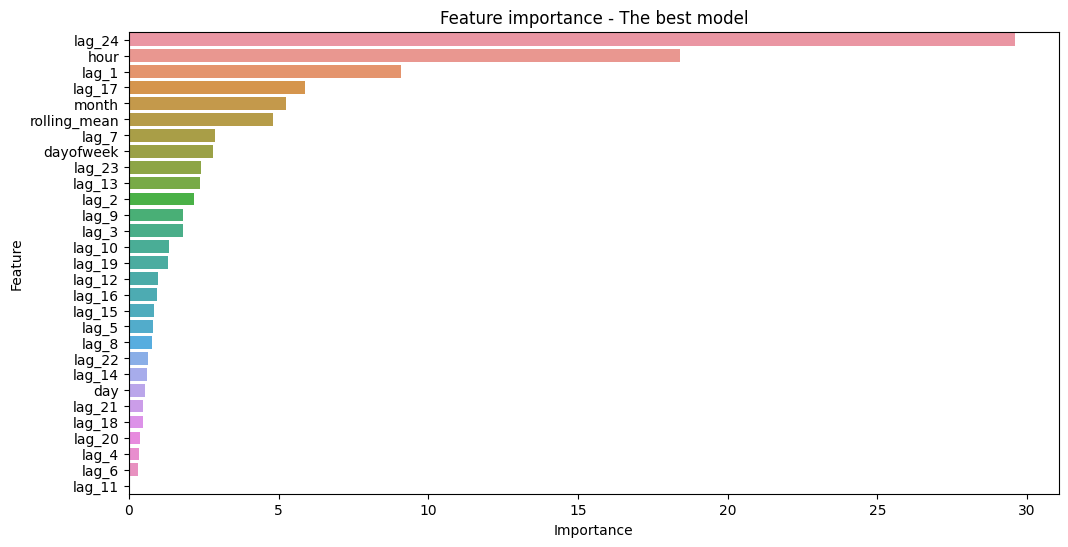

In [15]:
#feature importance
feature_importances = pd.DataFrame(
    {
        'Feature': data1.drop('num_orders', axis=1).columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
ax = sb.barplot(x='Importance', y='Feature', data=feature_importances) \
       .set(title='Feature importance - The best model')

**Results**

1. Predictions were made on the test dataset. RMSE on the test dataset: 44.86.
2. Feature importance was analyzed. The most important features are the previous value (-24h), hour, and the previous value (-1h). The least important features are the previous value (-11h), value (-6h), and value (-4h).


<AxesSubplot:title={'center':'Predicted and test values by the best model'}, xlabel='datetime'>

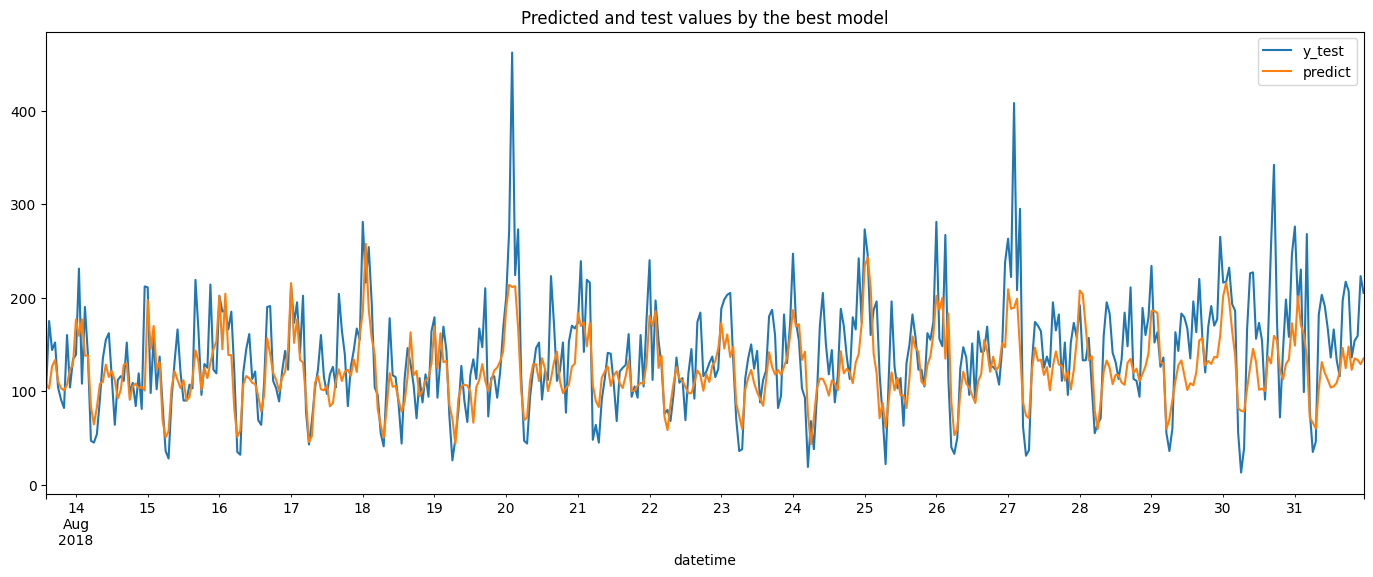

In [16]:
pred_test = pd.concat([pd.Series(y_test.values), pd.Series(pred)], axis=1, ignore_index=True).set_index(y_test.index)
pred_test.columns = ['y_test', 'predict']
pred_test.plot(figsize=(17, 6), title='Predicted and test values by the best model')

## Conclusion

1. The data has been loaded, dates set as indices, and the data period ranges from 2018-03-01 00:00:00 to 2018-08-31 23:50:00. Resampling was performed with a one-hour frequency (the number of orders was summed).

2. The data was analyzed:
   - From March to August, the number of taxi orders increased.
   - A daily cyclic pattern was observed in the number of orders – more orders in the evening, with a decrease at night.


3. New features were created: hour, day, month, weekday, 24 previous lag features, and a 12-day moving average.

4. Three types of models were trained:

   - Model 0 – Linear Regression (Ridge): RMSE of the best model during cross-validation: 27.11
   - Model 1 – Gradient Boosting with CatBoost (iterating over the number of iterations): RMSE of the best model during cross-validation: 26.29
   - Model 2 – Decision Tree: RMSE of the best model during cross-validation: 30.21


    The RMSE metric was minimal for the CatBoost gradient boosting model. The best model was found.

5. Predictions were made on the test dataset. RMSE on the test dataset: 44.86. The RMSE on the test dataset did not exceed 48.
